In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft, optimize
import os

In [2]:
from ImgProcess import *     # import all functions from ../Codes/ImgProcessing.py
from KSVD import *              # import all functions from ../Codes/KSVD.py

# 0. read the images

In [3]:
path = os.listdir('../Pictures/')
imgs_gray = []
# read all .png files in ../Pictures/ (i.e. the gray-scale images)
for file in [file for file in path if file.endswith('.png')]:
    imgs_gray.append(plt.imread('../Pictures/' + file))

In [24]:
path = os.listdir('../Pictures/McM/')

imgs_clear = []
for file in [file for file in path if 'noise' not in file and file.endswith('.tif')]:
    _img = plt.imread('../Pictures/McM/' + file)    # extract the color channels
    imgs_clear.append([_img[:,:,0], _img[:,:,1], _img[:,:,2]])

imgs_noise = []
for file in [file for file in path if 'noise' in file and file.endswith('.tif')]:
    _img = plt.imread('../Pictures/McM/' + file)    # extract the color channels
    imgs_noise.append([_img[:,:,0], _img[:,:,1], _img[:,:,2]])

# Step 1. Cut the image into patches

In [5]:
size = 2**(5*2)
overlapping_rate = 0.25
mDCT = fft.dct(np.eye(size*2), norm='ortho')[:size]

# Step 2: Create the initial dictionary

initial dictionary: DCT over-complete dictionary

# Step 3: K-SVD

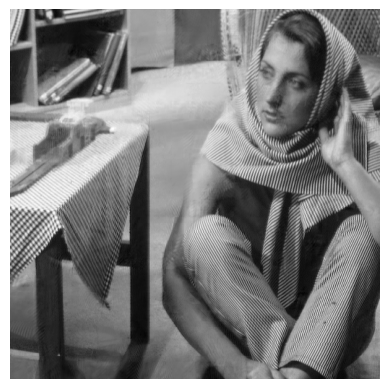

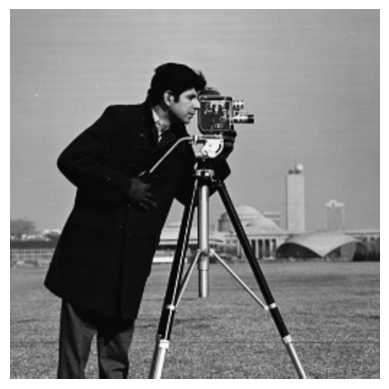

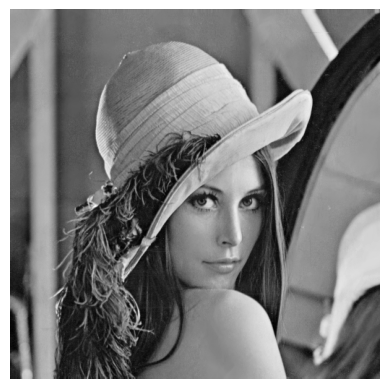

In [6]:
dicts = []
img_grayScale_learned = []
for img in img_grayScale:
    patches, DC_component = Img2patch(img, size, overlapping_rate)
    patches, dictionary, _ = KSVD(patches, mDCT, 4)

    dicts.append(dictionary)
    img_learned = Img2patch(patches, overlapping_rate, DC_component, inv=True)
    img_grayScale_learned.append(img_learned)
    
    Showing(img_learned)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


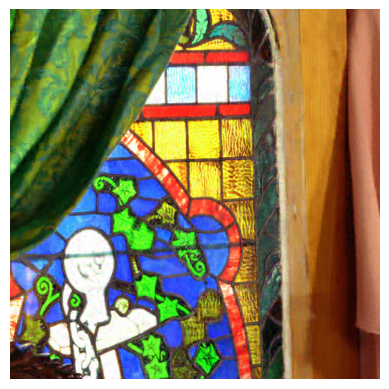

In [6]:
img_01_ = []
for img in img_01_color:
    size = 400
    overlapping_rate = 0.2
    mDCT = fft.dct(np.eye(size*2), norm='ortho')[:size]

    patches, DC_component = Img2patch(img, size, overlapping_rate)
    patches, dictionary, _ = KSVD(patches, mDCT, 4)

    # dicts.append(dictionary)
    img_learned = Img2patch(patches, overlapping_rate, DC_component, inv=True)
    img_01_.append(img_learned)

Showing(*img_01_)

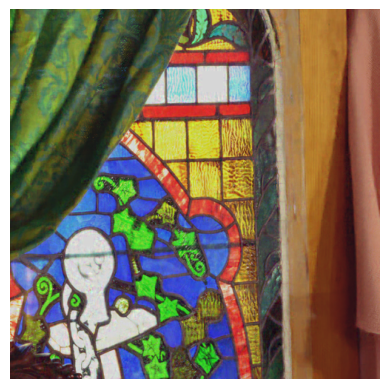

In [12]:
img_01__ = [(img_ - np.min(img_)) / (np.max(img_) - np.min(img_)) for img_ in img_01_]
Showing(*img_01__)